## Core Topics of Artificial Intelligence - Research Project

Author: Niccolò Howard Minetti
Date: First semester 2020
University: Tilburg University
Course: Core Topics of A.I.

Audio analysis of debates to highlight featurs of asynchrony or a-mimicry

In [20]:
# Import libraries
import librosa
import parselmouth
import numpy as np
import pandas as pd
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Introduction: Assumptions, Research Question, Data, Approach and Expectations

The objective of this research assignment was to analyse Mimicry and/or Synchrony in a diadic interaction. The research question was the following: 

Is it possible to detect disagreement in dyadic conversation using asynchrony and a-mimicry of pitch?  

We explore the tendencies of pitch in speach of a diadic podcast between Jordan Peterson and Russel Brand, famously renound on youtube as a example of 'civil dissagreement' because of a small clip titled 'This is was a Healthy Disagreement Looks like" was reposted. 

Log of steps that have been performed:

1. After having downloaded the audio file we proceed to labelling the interation. We first labelled a small sample, about 10% of the total, to have data to work with, and more labelling is added down the road. Current state 100%

2. The original audio file is split into two, one for each speaker, and fundamental pitch extraction is performed using the Praat through the Parselmouth python library.

3. Because of the discontinuous nature of the pitch data we apply smoothing by performing 3 rolling averages on the data with window size of (100, 200, 300) and correct the average by alligning average before and after the rolling. This is necessary because of the discontinuous nature of pitch data which includes empty values.

4. We then subtract the mean pitch of the speaker to get distance from nominal pitch. After having done so we add the two signals back together to get a single array of values which represent the distance from average pitch of which ever speaker is talking. We then perform a rolling mean (600) to smoothen out jumps from one speaker to the next.

5. We first apply Autocorrelation to this last signal, but since autocorrelation tries to find lagged patterns and we are working with interactions of different length, we can see the autocorrelation plot falling short.

6. A second methodology is proposed by averaging the value of every segment of speach. This way, since the interaction is dyadic and mutually exclusive, we can align the outputs and see if there are trends. To check for spurious correlation we calculate autocorrelation on each signal and apply pre-whiteing.

## Data Preparation

In [2]:
# Importing and data
path = 'dataset/RB_JP_46.wav'

# NOTE: Still works with sr within [5k, inf), tested on: 11025, 22050, 30000, 44100
x, sr = librosa.load(path, sr=30000)


In [3]:
print('x: ',type(x))
print('max(x): ', np.max(x))
print('min(x): ', np.min(x))
print('Sample rate: ', sr)

x:  <class 'numpy.ndarray'>
max(x):  1.0306975
min(x):  -1.0481237
Sample rate:  30000


## Labeling

    Interval           Total sec 
    00:00 - 00:48 RB      48 sec
    00:48 - 00:50 JP      50 sec
    00:50 - 01:18 RB      78 sec
    01:18 - 02:55 JP     175 sec
    02:55 - 02:58 RB     178 sec
    02:58 - 03:23 JP     203 sec
    03:23 - 03:55 RB     235 sec
    03:55 - 05:40 JP     340 sec
    05:40 - 06:18 RB     378 sec
    06:18 - 07:45 JP     465 sec
    07:45 - 08:14 RB     494 sec
    08:14 - 08:35 JP     515 sec
    08:35 - 08:38 RB     518 sec
    08:38 - 09:22 JP     562 sec
    09:23 - 09:33 RB     573 sec
    09:33 - 10:09 JP     609 sec
    10:09 - 10:12 RB     612 sec
    10:12 - 10:41 JP     641 sec ------ VALIDATION START
    10:41 - 10:43 RB     643 sec
    10:43 - 12:33 JP     753 sec
    12:33 - 13:03 RB     783 sec
    13:03 - 13:50 JP     830 sec
    13:50 - 14:16 RB     855 sec
    14:16 - 14:52 JP     892 sec
    14:52 - 15:41 RB     941 sec
    15:41 - 15:45 JP     945 sec
    15:45 - 15:48 RB     948 sec
    15:48 - 15:56 JP     956 sec
    15:56 - 16:00 RB     960 sec
    16:00 - 16:10 JP     970 sec
    16:10 - 16:14 RB     974 sec
    15:14 - 16:36 JP     996 sec
    16:36 - 17:17 RB    1037 sec
    17:17 - 17:19 JP    1039 sec
    17:19 - 17:22 RB    1042 sec
    17:22 - 17:51 JP    1071 sec
    17:51 - 17:58 RB    1078 sec
    17:58 - 18:18 JP    1098 sec
    18:18 - 18:34 RB    1114 sec
    18:34 - 19:12 JP    1152 sec
    19:12 - 19:14 RB    1154 sec
    19:14 - 19:44 JP    1184 sec
    19:44 - 20:25 RB    1225 sec
    20:25 - 20:50 JP    1250 sec
    20:50 - 22:03 RB    1323 sec
    22:03 - 23:06 JP    1386 sec ----- VALIDATION END
    23:06 - 23:17 RB    1397 sec
    23:17 - 23:23 JP    1403 sec
    23:23 - 23:25 RB    1405 sec
    23:25 - 24:42 JP    1482 sec
    24:42 - 24:50 RB    1490 sec
    24:50 - 25:26 JP    1526 sec
    25:26 - 25:28 RB    1528 sec
    25:28 - 26:00 JP    1560 sec
    26:00 - 26:03 RB    1563 sec
    26:03 - 27:50 JP    1670 sec
    27:50 - 27:54 RB    1674 sec
    27:54 - 28:05 JP    1685 sec
    28:05 - 28:27 RB    1707 sec
    28:27 - 31:01 JP    1861 sec
    31:01 - 31:11 RB    1871 sec
    31:11 - 31:22 JP    1882 sec
    31:22 - 33:36 RB    2016 sec
    33:36 - 38:42 JP    2322 sec
    38:42 - 38:55 RB    2335 sec
    38:55 - 38:58 JP    2338 sec
    38:55 - 39:49 RB    2389 sec
    39:49 - 40:11 JP    2411 sec
    40:11 - 40:13 RB    2413 sec
    40:13 - 40:14 JP    2414 sec
    40:14 - 40:23 RB    2423 sec
    40:23 - 40:28 JP    2428 sec
    40:28 - 40:33 RB    2433 sec
    40:33 - 40:36 JP    2436 sec
    40:36 - 40:41 RB    2441 sec
    40:41 - 40:43 JP    2443 sec
    40:43 - 40:59 RB    2459 sec
    40:59 - 41:06 JP    2466 sec
    41:06 - 41:07 RB    2467 sec
    41:07 - 41:37 JP    2497 sec
    41:37 - 42:53 RB    2573 sec
    42:53 - 42:58 JP    2578 sec
    42:58 - 43:02 RB    2582 sec
    43:02 - 43:13 JP    2593 sec
    32:13 - 43:26 RB    2606 sec
    43:26 - 43:38 JP    2618 sec
    43:38 - 43:41 RB    2621 sec
    43:41 - 43:43 JP    2623 sec
    43:43 - 44:09 RB    2649 sec
    44:09 - 44:14 JP    2654 sec
    44:14 - 44:19 RB    2659 sec
    44:19 - 44:39 JP    2679 sec
    44:39 - 44:41 RB    2681 sec
    44:41 - 44:51 JP    2691 sec
    44:51 - 45:12 RB    2712 sec
    45:12 - 45:54 JP    2754 sec
    45:54 - 46:16 RB    2776 sec
    46:16 - 46:29 JP    2789 sec
    46:29 - 48:34 RB    2914 sec
    48:34 - 52:17 JP    3137 sec
    52:17 - 53:36 RB    3216 sec
    53:36 - 53:41 JP    3221 sec
    53:41 - 53:45 RB    3225 sec
    53:45 - 53:50 JP    3230 sec
    53:50 - 54:25 RB    3265 sec
    54:25 - 54:40 JP    3280 sec
    54:40 - 54:44 RB    3284 sec
    54:44 - 54:50 JP    3290 sec
    54:50 - 54:55 RB    3295 sec
    54:55 - 54:57 JP    3297 sec
    54:57 - 55:00 RB    3300 sec
    55:00 - 55:17 JP    3317 sec
    55:17 - 55:30 RB    3330 sec
    55:30 - 55:34 JP    3334 sec
    55:34 - 55:36 RB    3336 sec
    55:36 - 56:00 JP    3360 sec
    56:00 - 56:04 RB    3364 sec
    56:04 - 56:06 JP    3366 sec
    56:06 - 56:14 RB    3374 sec
    56:14 - 56:24 JP    3384 sec
    56:24 - 56:43 RB    3403 sec
    56:43 - 57:22 JP    3442 sec
    57:22 - 57:25 RB    3445 sec
    57:25 - 57:36 JP    3456 sec
    57:36 - 57:53 RB    3473 sec
    57:53 - 58:01 JP    3481 sec
    58:01 - 58:04 RB    3484 sec
    58:04 - 59:53 JP    3593 sec
    59:53 - 60:11 RB    3611 sec
    60:11 - 60:39 JP    3639 sec
    60:39 - 60:58 RB    3658 sec
    60:58 - 61:13 JP    3673 sec
    61:13 - 61:15 RB    3675 sec
    61:15 - 61:29 JP    3689 sec
    61:29 - 61:38 RB    3698 sec
    61:38 - 61:40 JP    3700 sec
    61:40 - 62:52 RB    3772 sec
    62:58 - 63:01 JP    3781 sec
    63:01 - 63:12 RB    3792 sec
    63:12 - 67:00 JP    4020 sec
    67:00 - 67:04 RB    4024 sec
    67:04 - 67:35 JP    4055 sec
    67:35 - 67:48 RB    4068 sec
    67:48 - 67:51 JP    4071 sec
    67:51 - 68:07 RB    4087 sec
    68:07 - 68:10 JP    4090 sec
    68:10 - 68:22 RB    4102 sec
    68:22 - 68:30 JP    4110 sec
    68:30 - 69:42 RB    4122 sec
    69:42 - 69:46 JP    4126 sec
    69:46 - 69:49 RB    4129 sec
    69:49 - 70:10 JP    4210 sec
    70:10 - 70:25 RB    4225 sec
    70:25 - 70:31 JP    4231 sec
    70:31 - 70:36 RB    4236 sec
    70:36 - 70:46 JP    4246 sec
    70:46 - 71:25 RB    4285 sec
    70:25 - 71:28 JP    4288 sec
    70:28 - 71:40 RB    4300 sec
    71:40 - 71:45 JP    4305 sec
    71:45 - 71:50 RB    4310 sec
    71:50 - 71:53 JP    4313 sec
    71:53 - 72:37 RB    4357 sec
    72:37 - 72:57 JP    4377 sec
    72:57 - 72:59 RB    4379 sec
    72:59 - 73:22 JP    4402 sec
    73:22 - 73:30 RB    4410 sec
    73:30 - 73:32 JP    4412 sec
    73:32 - 73:40 RB    4420 sec
    73:40 - 73:47 JP    4427 sec
    73:47 - 73:52 RB    4432 sec
    73:52 - 73:56 JP    4436 sec
    73:56 - 74:00 RB    4440 sec
    74:00 - 74:06 JP    4446 sec
    74:06 - 74:33 RB    4473 sec
    74:33 - 75:40 JP    4540 sec
    75:40 - 75:48 RB    4548 sec
    75:48 - 76:23 JP    4583 sec
    76:23 - 77:01 RB    4621 sec
    77:01 - 77:16 JP    4635 sec
    77:16 - 77:48 RB    4668 sec
    77:48 - 77:50 JP    4670 sec
    77:50 - 78:59 RB    4739 sec
    78:59 - 79:30 JP    4770 sec
    79:30 - 79:37 RB    4777 sec
    79:37 - 80:57 JP    4857 sec
    80:57 - 81:01 RB    4861 sec
    81:01 - 81:49 JP    4909 sec
    81:49 - 82:41 RB    4961 sec
    82:41 - 82:46 JP    4966 sec
    82:46 - 83:27 RB    5007 sec
    83:27 - 83:31 JP    5011 sec
    83:31 - 83:33 RB    5013 sec
    83:33 - 83:36 JP    5016 sec
    83:36 - 83:59 RB    5039 sec
    83:59 - 84:30 JP    5070 sec
    84:30 - 84:45 RB    5085 sec
    84:45 - 84:52 JP    5092 sec
    84:52 - 85:12 RB    5112 sec
    85:12 - 85:36 JP    5136 sec
    85:36 - 85:43 RB    5143 sec
    85:43 - 85:46 JP    5146 sec
    85:46 - 85:48 RB    5148 sec
    85:48 - 85:57 JP    5157 sec
    85:57 - 86:06 RB    5166 sec
    86:06 - 87:09 JP    5229 sec
    87:09 - 87:14 RB    5234 sec
    87:14 - 87:27 JP    5247 sec
    87:27 - 87:29 RB    5249 sec
    87:29 - 88:01 JP    5281 sec
    88:01 - 88:05 RB    5285 sec
    88:05 - 89:46 JP    5386 sec
    89:46 - 89:55 RB    5395 sec
    89:56 - 90:10 JP    5410 sec
    90:10 - 90:20 RB    5420 sec

In [4]:
labels_rb = [[0, 48], [50, 78], [175, 178], [203, 235], 
             [340, 378], [465, 494], [515, 518], [562, 573],
             [609, 612], [641, 643], [753, 783], [830, 855],
             [892, 941], [945, 948], [956, 960], [970, 974],
             [996, 1037], [1039,1042],[1071, 1078], [1098, 1114], 
             [1152, 1154], [1184, 1225],
             [1250, 1323], [1386, 1397], [1403, 1405], [1482, 1490],
             [1526, 1528], [1560, 1563], [1670, 1674], [1685, 1707],
             [1861, 1871], [1882, 2016], [2322, 2335], [2338, 2389],
             [2411, 2413], [2414, 2423], [2428, 2433], [2436, 2441],
             [2443, 2459], [2466, 2467], [2497, 2573], [2578, 2582],
             [2593, 2606], [2618, 2621], [2623, 2649], [2654, 2659],
             [2679, 2681], [2691, 2712], [2754, 2776], [2789, 2914],
             [3137, 3216], [3221, 3225], [3230, 3265], [3280, 3284],
             [3290, 3295], [3297, 3300], [3317, 3330], [3334, 3336],
             [3360, 3364], [3366, 3374], [3384, 3403], [3442, 3445],
             [3456, 3473], [3481, 3484], [3593, 3611], [3639, 3658],
             [3673, 3675], [3689, 3698], [3700, 3772], [3781, 3792],
             [4020, 4024], [4055, 4068], [4071, 4087], [4090, 4102],
             [4110, 4122], [4126, 4129], [4210, 4225], [4231, 4236],
             [4246, 4285], [4288, 4300], [4305, 4310], [4313, 4357],
             [4377, 4379], [4402, 4410], [4412, 4420], [4427, 4432],
             [4436, 4440], [4446, 4473], [4540, 4548], [4583, 4621],
             [4635, 4668], [4670, 4739], [4770, 4777], [4857, 4861],
             [4909, 4961], [4966, 5007], [5011, 5013], [5016, 5039],
             [5070, 5085], [5092, 5112], [5136, 5143], [5146, 5148],
             [5157, 5166], [5229, 5234], [5247, 5249], [5281, 5285],
             [5386, 5395], [5410, 5420]]


labels_jp = []

# Binary complementary labels
for index in range(len(labels_rb) - 1):
    labels_jp.append([labels_rb[ index ][ 1 ], labels_rb[ index + 1 ][ 0 ]])
             
# Sample rate conversion
for list_a in range(len(labels_rb)):
    labels_rb[list_a][0] = labels_rb[list_a][0] * sr
    labels_rb[list_a][1] = labels_rb[list_a][1] * sr
    
for list_a in range(len(labels_jp)):
    labels_jp[list_a][0] = labels_jp[list_a][0] * sr
    labels_jp[list_a][1] = labels_jp[list_a][1] * sr

print("Last three JP labels: ", labels_jp[-3:])
print("Last three RB labels: ", labels_rb[-3:])

Last three JP labels:  [[157470000, 158430000], [158550000, 161580000], [161850000, 162300000]]
Last three RB labels:  [[158430000, 158550000], [161580000, 161850000], [162300000, 162600000]]


In [5]:
# Copy the sample, and split it by setting to zero values given in the intervals
jp_wav = np.array(x)
rb_wav = np.array(x)

# Setting to zero when the other speaking is talking
for rb_element in labels_rb:
    jp_wav[rb_element[0] : rb_element[1]] = 0
    
    
for jp_element in labels_jp:
    rb_wav[jp_element[0] : jp_element[1]] = 0
    

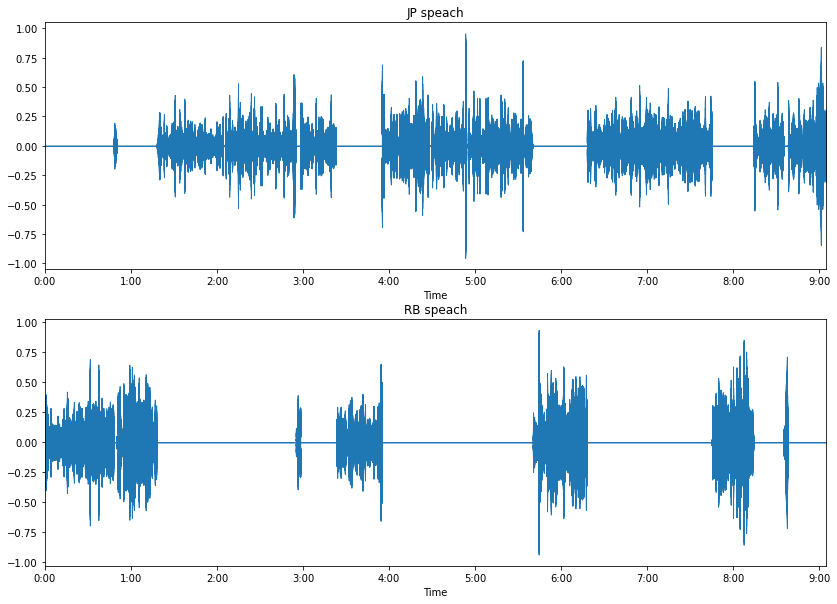

In [6]:
# Plot 10% of the signal, this should show alternating interaction
plt.figure(figsize=(14, 10))

plt.subplot(211)
plt.title('JP speach')
librosa.display.waveplot(jp_wav[:round(0.10*len(jp_wav))], sr=sr);

plt.subplot(212)
plt.title('RB speach')
librosa.display.waveplot(rb_wav[:round(0.10*len(rb_wav))], sr=sr);

## Pitch detection

In [7]:
# Extracting pitch
snd_jp = parselmouth.Sound(jp_wav)
snd_rb = parselmouth.Sound(rb_wav)

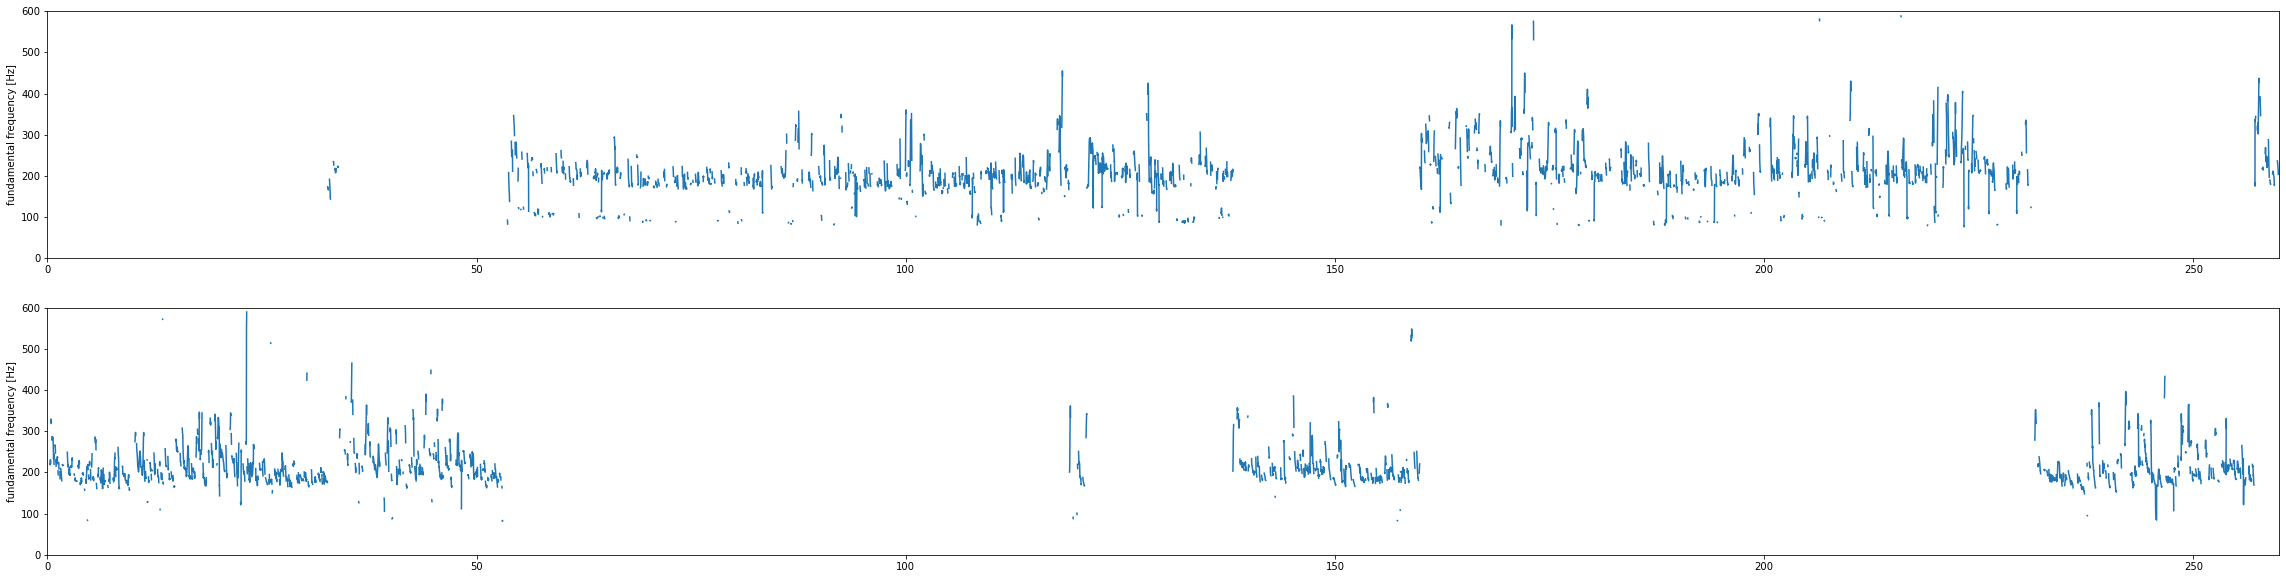

In [8]:
# Plot Pitch
plt.figure(figsize=(40,10))

# JP
pitch_jp = snd_jp.to_pitch()
pitch_values_jp = pitch_jp.selected_array['frequency']
pitch_values_jp[pitch_values_jp==0] = np.nan

# Plot
plt.subplot(211)

plt.plot(pitch_jp.xs(), pitch_values_jp)#, 'o', markersize=2)
plt.grid(False)
plt.ylim(0, pitch_jp.ceiling)
plt.xlim(0,260)
plt.ylabel("fundamental frequency [Hz]")


# RB
pitch_rb = snd_rb.to_pitch()
pitch_values_rb = pitch_rb.selected_array['frequency']
pitch_values_rb[pitch_values_rb==0] = np.nan

# Plot
plt.subplot(212)

plt.plot(pitch_rb.xs(), pitch_values_rb)#, 'o', markersize=2)
plt.grid(False)
plt.ylim(0, pitch_rb.ceiling)
plt.xlim(0,260)
plt.ylabel("fundamental frequency [Hz]")

plt.show();

In [9]:
# JP

print("Jordan Peterson")

pitch_jp_arr = pitch_jp.selected_array['frequency']
print("length: " + str(pitch_jp_arr.size) + " Nonzero: " + str(np.count_nonzero(pitch_jp_arr)))

# Compute average
sum_nonzero = sum(pitch_jp_arr[np.nonzero(pitch_jp_arr)])
n_nonzero = np.count_nonzero(pitch_jp_arr)
jp_pitch_mean = sum_nonzero / n_nonzero

print("Mean: ", round(jp_pitch_mean, 2))


# RB

print("\nRussel Brand")

pitch_rb_arr = pitch_rb.selected_array['frequency']
print("length: " + str(pitch_rb_arr.size) + " Nonzero: " + str(np.count_nonzero(pitch_rb_arr)))

# Compute average
sum_nonzero = sum(pitch_rb_arr[np.nonzero(pitch_rb_arr)])
n_nonzero = np.count_nonzero(pitch_rb_arr)
rb_pitch_mean = sum_nonzero / n_nonzero

print("Mean: ", round(rb_pitch_mean, 2) )

# Conversion factor (number of samples produce after pitch extraction)
conv_rate = (sr*pitch_rb_arr.size)/labels_jp[-1][1]

print("\n\nSR to Pitch factor: ",(sr*pitch_rb_arr.size)/labels_jp[-1][1])

Jordan Peterson
length: 370636 Nonzero: 96437
Mean:  239.06

Russel Brand
length: 370636 Nonzero: 78013
Mean:  230.38


SR to Pitch factor:  68.509426987061


## Sliding window pitch average - JP

Mean:  95.31


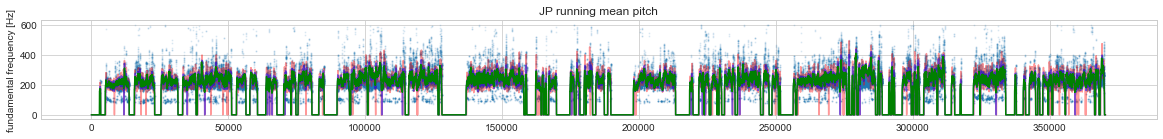

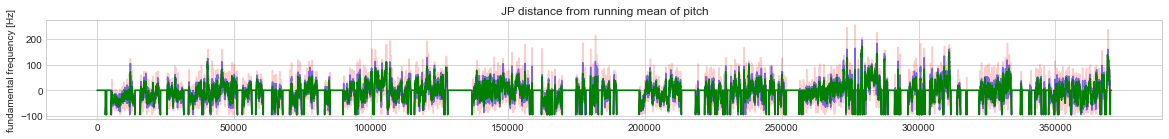

In [10]:
plt.style.use('seaborn-whitegrid')
# Jordan Peterson

rmean_300_jp = np.convolve(pitch_jp_arr, np.ones((300,))/(300), mode='valid')

rmean_200_jp = np.convolve(pitch_jp_arr, np.ones((200,))/200, mode='valid')

rmean_100_jp = np.convolve(pitch_jp_arr, np.ones((100,))/100, mode='valid')


# Correcting average rmean

sum_nonzero = sum(rmean_100_jp[np.nonzero(rmean_100_jp)])
n_nonzero = np.count_nonzero(rmean_100_jp)
new_jp_mean = sum_nonzero / n_nonzero

print("Mean: ", round(new_jp_mean, 2))
delta_mean = jp_pitch_mean-new_jp_mean
rmean_100_jp[rmean_100_jp != 0] += delta_mean
rmean_200_jp[rmean_200_jp != 0] +=  delta_mean
rmean_300_jp[rmean_300_jp != 0] +=  delta_mean

################################### GRAPHS ##################################

# JP running mean pitch

plt.figure(figsize=(20,4))

plt.subplot(211, title="JP running mean pitch")

plt.plot(pitch_values_jp, 'o', markersize=1, alpha= 0.1)

plt.plot( rmean_100_jp, 'r', alpha=0.4)
plt.plot( rmean_200_jp, 'b', alpha=0.5)
plt.plot( rmean_300_jp, 'g')
plt.ylabel("fundamental frequency [Hz]")
plt.show();


# JP distance from running mean of pitch

plt.figure(figsize=(20,4))

plt.subplot(211, title="JP distance from running mean of pitch")

# Fixing zero values

t_jp_1 = rmean_100_jp.copy()
t_jp_2 = rmean_200_jp.copy()
t_jp_3 = rmean_300_jp.copy()
t_jp_1[t_jp_1 != 0] -= jp_pitch_mean
t_jp_2[t_jp_2 != 0] -= jp_pitch_mean
t_jp_3[t_jp_3 != 0] -= jp_pitch_mean

plt.plot( t_jp_1, 'r', alpha=0.2)
plt.plot( t_jp_2, 'b', alpha=0.5)
plt.plot( t_jp_3, 'g')
plt.ylabel("fundamental frequency [Hz]")
plt.show();

## Sliding window pitch average - RB

Mean:  121.91


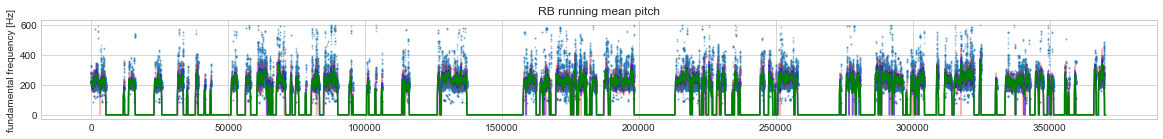

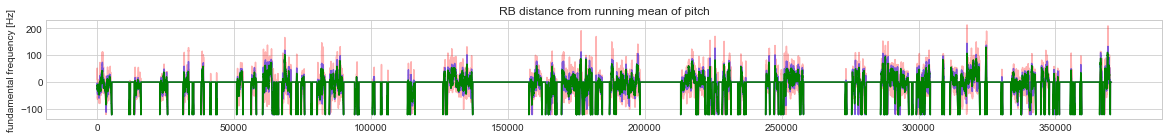

In [11]:
# Russel Brand

rmean_300_rb = np.convolve(pitch_rb_arr, np.ones((300,))/300, mode='valid')

rmean_200_rb = np.convolve(pitch_rb_arr, np.ones((200,))/200, mode='valid')

rmean_100_rb = np.convolve(pitch_rb_arr, np.ones((100,))/100, mode='valid')

# Correcting average rmean
sum_nonzero = sum(rmean_100_rb[np.nonzero(rmean_100_rb)])
n_nonzero = np.count_nonzero(rmean_100_rb)
new_rb_mean = sum_nonzero / n_nonzero

print("Mean: ", round(new_rb_mean, 2))
delta_mean = rb_pitch_mean-new_rb_mean
rmean_100_rb[rmean_100_rb != 0] += delta_mean
rmean_200_rb[rmean_200_rb != 0] +=  delta_mean
rmean_300_rb[rmean_300_rb != 0] +=  delta_mean

################################### GRAPHS ##################################

# RB running mean pitch

plt.figure(figsize=(20,4))
plt.subplot(211, title="RB running mean pitch")

plt.plot(pitch_values_rb, 'o', markersize=1, alpha= 0.3)

plt.plot( rmean_100_rb, 'r', alpha=0.3)
plt.plot( rmean_200_rb, 'b', alpha=0.5)
plt.plot( rmean_300_rb, 'g')
plt.ylabel("fundamental frequency [Hz]")

# RB distance from running mean of pitch

plt.figure(figsize=(20,4))
plt.subplot(211, title="RB distance from running mean of pitch")

# Fixing zero values

t_rb_1 = rmean_100_rb.copy()
t_rb_2 = rmean_200_rb.copy()
t_rb_3 = rmean_300_rb.copy()
t_rb_1[t_rb_1 != 0] -= rb_pitch_mean
t_rb_2[t_rb_2 != 0] -= rb_pitch_mean
t_rb_3[t_rb_3 != 0] -= rb_pitch_mean

plt.plot( t_rb_1, 'r', alpha=0.3)
plt.plot( t_rb_2, 'b', alpha=0.5)
plt.plot( t_rb_3, 'g')
plt.ylabel("fundamental frequency [Hz]");

Gray is JP, White is RB


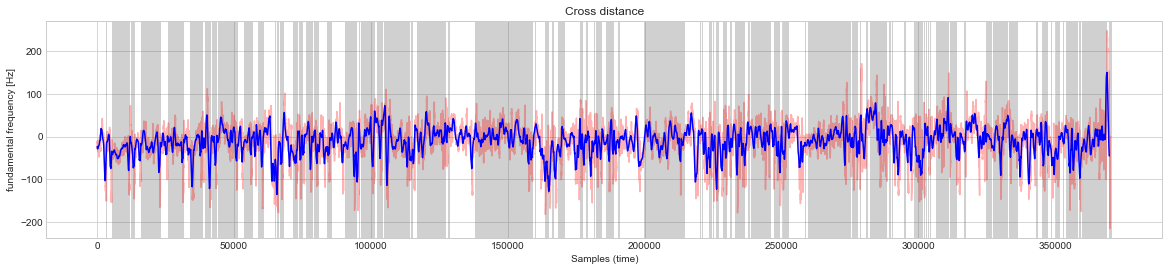

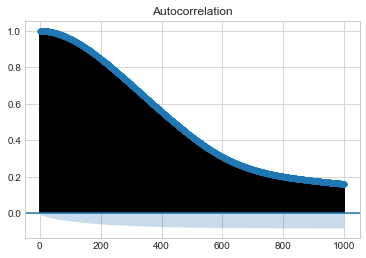

In [30]:
# Adding the relative distance to the speakers average, performing rolling mean (600)

cross_distance = t_jp_3 + t_rb_3

cross_avg_600 = np.convolve(cross_distance, np.ones((600,))/(600), mode='valid')

plt.figure(figsize=(20,4))

plt.plot( cross_distance, 'r', alpha=0.3)
plt.plot( cross_avg_600, 'b')

plt.title("Cross distance")
plt.xlabel("Samples (time)")
plt.ylabel("fundamental frequency [Hz]")
print("Gray is JP, White is RB")

for interval in labels_jp:
    plt.axvspan(interval[0]*conv_rate/sr, interval[1]*conv_rate/sr, facecolor='0.4', alpha=0.3)
    
plot_acf(cross_avg_600, lags=1000);

# Since we have a rolling average of 600, two indipendent frames would be at 1200 values apart 
# and autocorrelation falls off at 1000. This shows that autocorrelation is not effective in 
# this case, probably due to the difference in duration of each speech interval.

## Interval averages
Since autocorrelation hasn't given us good results, we can try a different approach.
This second approach extracts a point average of each speech segment so that the two signals are aligned.

In [13]:
# Single point average
intv_jp_mean = []

for interval in labels_jp[:]:
    
    intv_jp_mean.append(np.mean(cross_avg_600[int(interval[0]*conv_rate/sr) : int(interval[1]*conv_rate/sr)]))
    
intv_rb_mean = []

for interval in labels_rb[:-1]:
    
    intv_rb_mean.append(np.mean(cross_avg_600[int(interval[0]*conv_rate/sr) : int(interval[1]*conv_rate/sr)]))
    
# Distance error between the two values   
intv_error = []

for index in range(len(intv_jp_mean)):
    
    intv_error.append(abs(intv_jp_mean[index] - intv_rb_mean[index]))


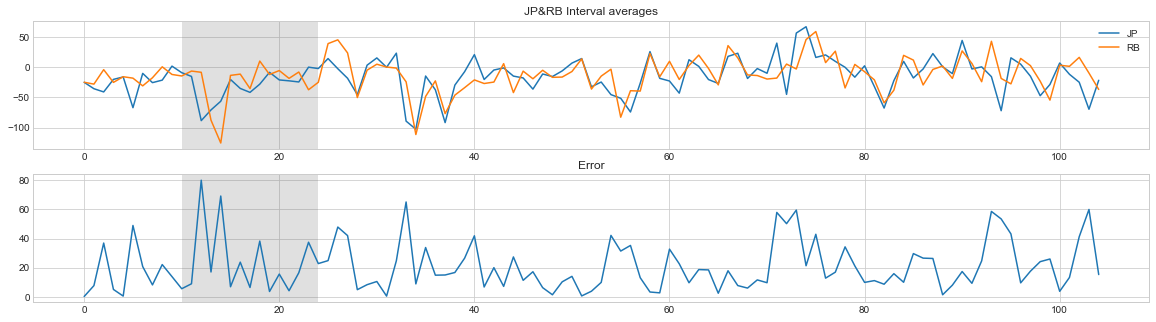

In [52]:
plt.figure(figsize=(20,8))

plt.subplot(311)
plt.title('JP&RB Interval averages')
plt.plot(intv_jp_mean[:-2])
plt.plot(intv_rb_mean[:-2])
plt.axvspan(10, 24, facecolor='0.4', alpha=0.2)
plt.legend(['JP', 'RB'])

plt.subplot(312)
plt.title('Difference between signals (Error)')
plt.plot(intv_error[:-2])
plt.axvspan(10, 24, facecolor='0.4', alpha=0.2)
plt.show();


In [15]:
# 80% threshold candidates
for error_index in range(len(intv_error[:-2])):
    
    if intv_error[error_index] > (0.80 * max(intv_error[:-2])):
        
        print(f"Index: {error_index}\nValue: {intv_error[error_index]}")
        print(f"RB timestamps: {round(labels_rb[error_index][0] / (sr * 60), 2), round(labels_rb[error_index][1] / (sr * 60), 2)}")
        print(f"JP timestamps: {round(labels_jp[error_index][0] / (sr * 60), 2), round(labels_jp[error_index][1] / (sr * 60), 2)}\n")
        

Index: 12
Value: 80.14660951702595
RB timestamps: (14.87, 15.68)
JP timestamps: (15.68, 15.75)

Index: 14
Value: 69.25019384371726
RB timestamps: (15.93, 16.0)
JP timestamps: (16.0, 16.17)

Index: 33
Value: 65.16755805688074
RB timestamps: (38.97, 39.82)
JP timestamps: (39.82, 40.18)



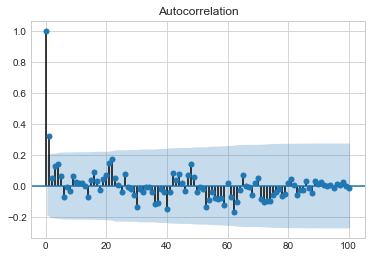

In [32]:
# JP Autocorrelation to rule out sturious correlation
plot_acf(intv_jp_mean, lags=100);

# Little if none autocorrelation is present, to be sure we apply pre-whitening to see
# if the same results persist.

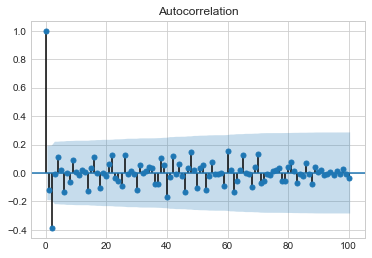

In [33]:
# Pre-whitening JP
model = ARIMA(intv_jp_mean, order=(1,1,0))
model_fit = model.fit()
residuals = pd.DataFrame(model_fit.resid)
pitch_values_e = list(residuals[0])

plot_acf(pitch_values_e, lags=100);

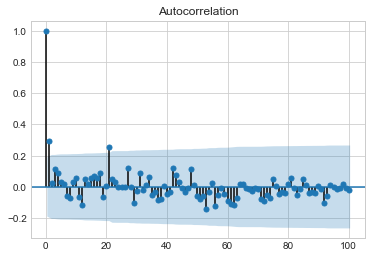

In [53]:
# RB Autocorrelation to rule out sturious correlation
plot_acf(intv_rb_mean, lags=100);


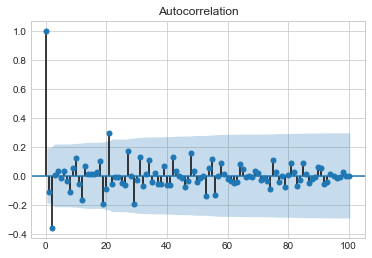

In [54]:
# RB
model_rb = ARIMA(intv_rb_mean, order=(1,1,0))
model_fit_rb = model_rb.fit()
residuals_rb = pd.DataFrame(model_fit_rb.resid)
pitch_values_e_rb = list(residuals_rb[0])

plot_acf(pitch_values_e_rb, lags=100);

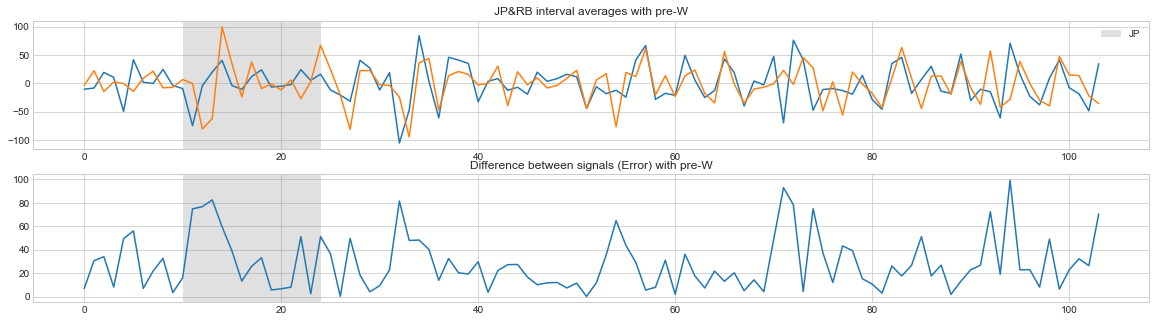

In [57]:
# Plot the results again to see if pre-whitening has changed the results.

intv_error_test = []

for index in range(len(pitch_values_e)):
    
    intv_error_test.append(abs(pitch_values_e[index] - pitch_values_e_rb[index]))

plt.figure(figsize=(20,8))

plt.subplot(311)
plt.title("JP&RB interval averages with pre-W")
plt.axvspan(10, 24, facecolor='0.4', alpha=0.2)
plt.legend(['JP', 'RB'])
plt.plot(pitch_values_e[:-2]);
plt.plot(pitch_values_e_rb[:-2]);

plt.subplot(312)
plt.title('Difference between signals (Error) with pre-W')
plt.axvspan(10, 24, facecolor='0.4', alpha=0.2)
plt.plot(intv_error_test[:-2]);


## Correlation doesn't seem to help differenciate between agreement and disagreement

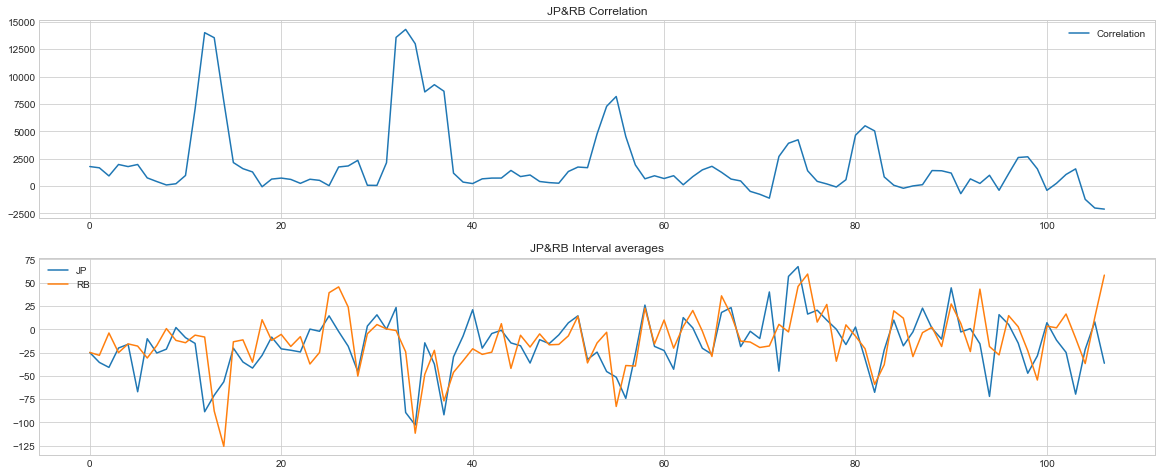

In [29]:
corr_values = []
ws = 3

for value in range(0, len(intv_jp_mean)):
    
    corr_values.append(np.correlate(intv_jp_mean[value : value + ws], intv_rb_mean[value : value + ws]))

    
plt.figure(figsize=(20,8))

plt.subplot(211)
plt.title('JP&RB Correlation')
plt.plot(corr_values);
plt.legend(['Correlation'])

plt.subplot(212)
plt.title('JP&RB Interval averages')
plt.plot(intv_jp_mean)
plt.plot(intv_rb_mean)
plt.legend(['JP', 'RB']);


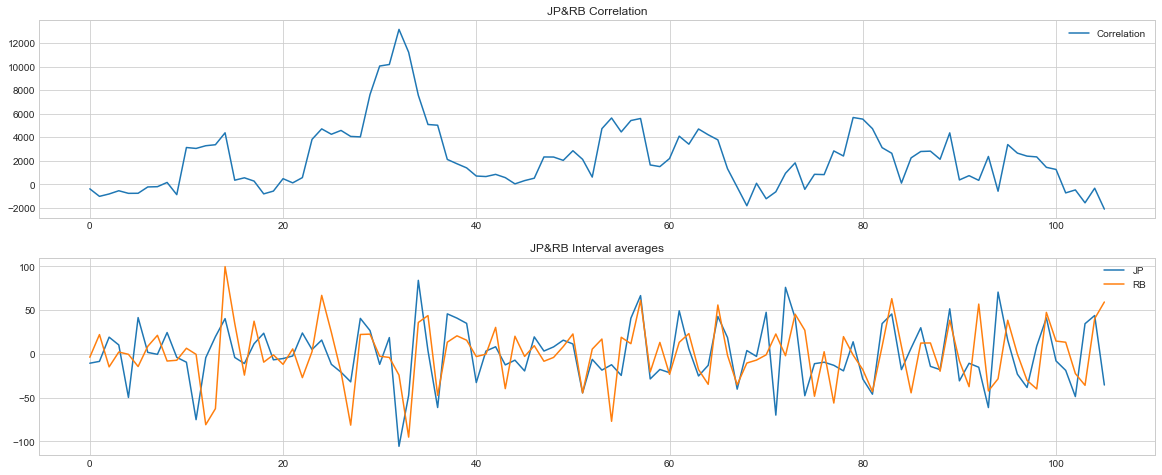

In [44]:
#

corr_values = []
ws = 5

for value in range(0, len(pitch_values_e)):
    
    corr_values.append(np.correlate(pitch_values_e[value : value + ws], pitch_values_e_rb[value : value + ws]))

    
plt.figure(figsize=(20,8))

plt.subplot(211)
plt.title('JP&RB Correlation')
plt.plot(corr_values);
plt.legend(['Correlation'])

plt.subplot(212)
plt.title('JP&RB Interval averages')
plt.plot(pitch_values_e)
plt.plot(pitch_values_e_rb)
plt.legend(['JP', 'RB']);



## Conclusion

In conclusion, this second methodology is very interesting in discovering moments of disagreement and future application will be explored such as detection of understanding.